In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random
from tqdm import tqdm

In [2]:
import layers as custom_layers

In [4]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# File Paths
imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [5]:
bs = 2

In [6]:
trainDataPath = "./affineTrainingData/affine{}.npz"
trainDataSize = 2000
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = fixedImg / np.max(fixedImg)
fixedImg = fixedImg.astype('float32')
fixedImg = np.expand_dims(fixedImg, axis=-1)

def img_pair_input_gen(batch_size = bs):
    while True:
        imgPair_batch = np.zeros((batch_size, *fixedImg.shape[:-1], 2))
        # fixedImg_batch = np.zeros((batch_size, *fixedImg.shape))
        # tgtAffineTrf_batch = np.zeros((batch_size, 12))
        for i in range(batch_size):
            idx = random.randrange(trainDataSize)
            inputObj = np.load(trainDataPath.format(idx))
            movingImg = inputObj['img']
            movingImg = np.expand_dims(movingImg, axis=-1)
            movingImg = movingImg.astype('float32')
            imgPair = np.concatenate([movingImg, fixedImg], axis=3)
            imgPair_batch[i] = imgPair

            # tgtAffineTrf = inputObj['trf']
            # tgtAffineTrf = tgtAffineTrf.astype('float32')
            # tgtAffineTrf_batch[i] = tgtAffineTrf
            # fixedImg_batch[i] = fixedImg
        
        yield imgPair_batch


def gt_fixed_img_input_gen(batch_size = bs):
    while True:
        fixedImg_batch = np.zeros((batch_size, *fixedImg.shape))
        for i in range(batch_size):
            fixedImg_batch[i] = fixedImg
        
        yield fixedImg_batch

In [7]:
img_pair_input = img_pair_input_gen()
gt_fixed_img_input = gt_fixed_img_input_gen()

## Define the generator

In [8]:
def make_generator(lrelu_alpha=0.3):
    def conv_activation(inputs):
        outputs = layers.BatchNormalization()(inputs)
        outputs = layers.LeakyReLU(alpha=lrelu_alpha)(outputs)
        return outputs

    inputs = keras.Input(shape = (*fixedImg.shape[:-1], 2))
    moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
    # fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

    down_depths = [32, 64, 128, 512]
    up_depths = [512, 128, 64, 32, 3]

    # Down-sampling path
    down_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(7, 15, 15), strides=(1, 1, 1), padding="same", activation=layers.LeakyReLU())(inputs)
    down_0 = layers.MaxPool3D((1, 2, 2), padding="same")(down_0)
    print("0: {}".format(down_0.shape))

    down_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), strides=(1, 2, 2), padding="same")(down_0)
    down_1 = conv_activation(down_1)
    down_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(down_1)
    down_1 = conv_activation(down_1)
    print("1: {}".format(down_1.shape))

    down_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(down_1)
    down_2 = conv_activation(down_2)
    down_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(down_2)
    down_2 = conv_activation(down_2)
    print("2: {}".format(down_2.shape))

    down_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(down_2)
    down_3 = conv_activation(down_3)
    down_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(down_3)
    down_3 = conv_activation(down_3)
    print("3: {}".format(down_3.shape))


    # Up-sampling path
    up_0 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(down_3)
    up_0 = conv_activation(up_0)
    up_0 = tf.concat([down_2, up_0], 4)
    up_0 = layers.Conv3D(filters=up_depths[0], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(up_0)
    up_0 = conv_activation(up_0)
    print("4: {}".format(up_0.shape))

    up_1 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(up_0)
    up_1 = conv_activation(up_1)
    up_1 = tf.concat([down_1, up_1], 4)
    up_1 = layers.Conv3D(filters=up_depths[1], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(up_1)
    up_1 = conv_activation(up_1)
    print("5: {}".format(up_1.shape))

    up_2 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 3, 3), strides=(1, 2, 2), padding="same")(up_1)
    up_2 = conv_activation(up_2)
    up_2 = tf.concat([down_0, up_2], 4)
    up_2 = layers.Conv3D(filters=up_depths[2], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(up_2)
    up_2 = conv_activation(up_2)
    print("6: {}".format(up_2.shape))


    up_3 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 3, 3), strides=(1, 2, 2), padding="same")(up_2)
    up_3 = conv_activation(up_3)
    up_3 = layers.Conv3D(filters=up_depths[3], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(up_3)
    up_3 = conv_activation(up_3)
    print("7: {}".format(up_3.shape))

    deformation_field_pred = layers.Conv3D(filters=up_depths[4], kernel_size=(3, 3, 3), strides=(1, 1, 1), padding="same")(up_3)
    print("8: {}".format(deformation_field_pred.shape))

    # affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
    deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, deformation_field_pred])

    model = keras.Model(inputs=inputs, outputs=deformable_warped, name="generator_model")
    model.summary()

    return model

In [9]:
generator = make_generator()

0: (None, 52, 128, 128, 32)
1: (None, 52, 64, 64, 64)
2: (None, 26, 32, 32, 128)
3: (None, 13, 16, 16, 512)
4: (None, 26, 32, 32, 512)
5: (None, 52, 64, 64, 128)
6: (None, 52, 128, 128, 64)
7: (None, 52, 256, 256, 32)
8: (None, 52, 256, 256, 3)
Instructions for updating:
Use fn_output_signature instead
Model: "generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52, 256, 256 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 52, 256, 256, 100832      input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 52, 128, 128, 0           conv3d[0][0]

## Define the discriminator

In [10]:
def make_discriminator(lrelu_alpha=0.3, drop_out_rate=0.2):
    def conv_activation(inputs):
        outputs = layers.BatchNormalization()(inputs)
        outputs = layers.LeakyReLU(alpha=lrelu_alpha)(outputs)
        outputs = layers.Dropout(drop_out_rate)(outputs)
        return outputs
    
    inputs = keras.Input(shape = fixedImg.shape)

    x = layers.Conv3D(filters=32, kernel_size=(7, 15, 15), strides=(1, 2, 2), padding="same")(inputs)
    x = conv_activation(x)

    x = layers.Conv3D(filters=64, kernel_size=(5, 5, 5), strides=(1, 2, 2), padding="same")(x)
    x = conv_activation(x)

    x = layers.Conv3D(filters=128, kernel_size=(5, 5, 5), strides=(2, 2, 2), padding="same")(x)
    x = conv_activation(x)

    x = layers.Conv3D(filters=256, kernel_size=(5, 5, 5), strides=(2, 2, 2), padding="same")(x)
    x = conv_activation(x)

    x = layers.Conv3D(filters=512, kernel_size=(5, 5, 5), strides=(2, 2, 2), padding="same")(x)
    x = conv_activation(x)

    x = layers.AveragePooling3D((2, 2, 2))(x)
    print(x.shape)
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = conv_activation(x)
    x = layers.Dense(32)(x)
    x = conv_activation(x)
    pred = layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=pred, name="discriminator_model")
#     model.summary()

    return model
    

In [11]:
discriminator = make_discriminator()

(None, 3, 4, 4, 512)


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss_rf(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
def generator_loss_t(real_output, fake_output):
    return mse(real_output, fake_output)

In [16]:
lr = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [17]:
checkpoint_dir = './GAN_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
@tf.function
def train_step(gt_fixed_images):
    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(next(img_pair_input), training=True)

      real_output = discriminator(gt_fixed_images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss_rf = generator_loss_rf(fake_output)
      gen_loss_t = generator_loss_t(real_output, fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator_rf = gen_tape.gradient(gen_loss_rf, generator.trainable_variables)
    gradients_of_generator_t = gen_tape.gradient(gen_loss_t, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator_rf, generator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator_t, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss_rf, gen_loss_t, disc_loss

In [19]:
def train(epochs, steps_per_epoch):
    train_gen_losses_rf = []
    train_gen_losses_t = []
    train_disc_losses = []
    for epoch in range(epochs):
        for step in tqdm(range(steps_per_epoch)):
            gt_fixed_img = next(gt_fixed_img_input)
            gen_loss_rf, gen_loss_t, disc_loss = train_step(gt_fixed_img)
            train_gen_losses_rf.append(gen_loss_rf)
            train_gen_losses_t.append(gen_loss_t)
            train_disc_losses.append(disc_loss)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print("Epoch {} finished".format(epoch))
    return train_gen_losses_rf, train_gen_losses_t, train_disc_losses

In [20]:
epochs = 50
steps_per_epoch = int(trainDataSize / bs)
train_gen_losses_rf, train_gen_losses_t, train_disc_losses = train(epochs, steps_per_epoch)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0 finished


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 1 finished


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 2 finished


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 3 finished


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [15:18<00:00,  4.59s/it]


Epoch 4 finished


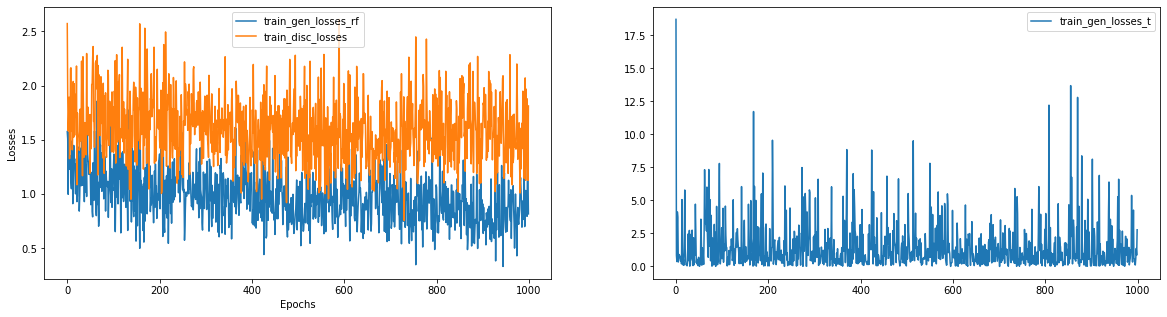

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))  # Create a figure and an axes.
axes[0].plot(range(len(train_gen_losses_rf)), train_gen_losses_rf, label='train_gen_losses_rf')
axes[0].plot(range(len(train_disc_losses)), train_disc_losses, label='train_disc_losses')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Losses')
axes[1].plot(range(len(train_gen_losses_t)), train_gen_losses_t, label='train_gen_losses_t')
# ax.set_title("Simple Plot")
axes[0].legend()
axes[1].legend()

## Test model (output == warpedImg)

In [ ]:
# test_generator = make_generator()

In [ ]:
# # testModel.load_weights('./checkpoints/epoch_{}'.format(epochs-1))
# ckpt = 
# test_generator.load_weights('./GAN_checkpoints/ckpt-10.data-00000-of-00001')

In [22]:
test_input = next(img_pair_input)
test_generated_images = generator(test_input, training=False)

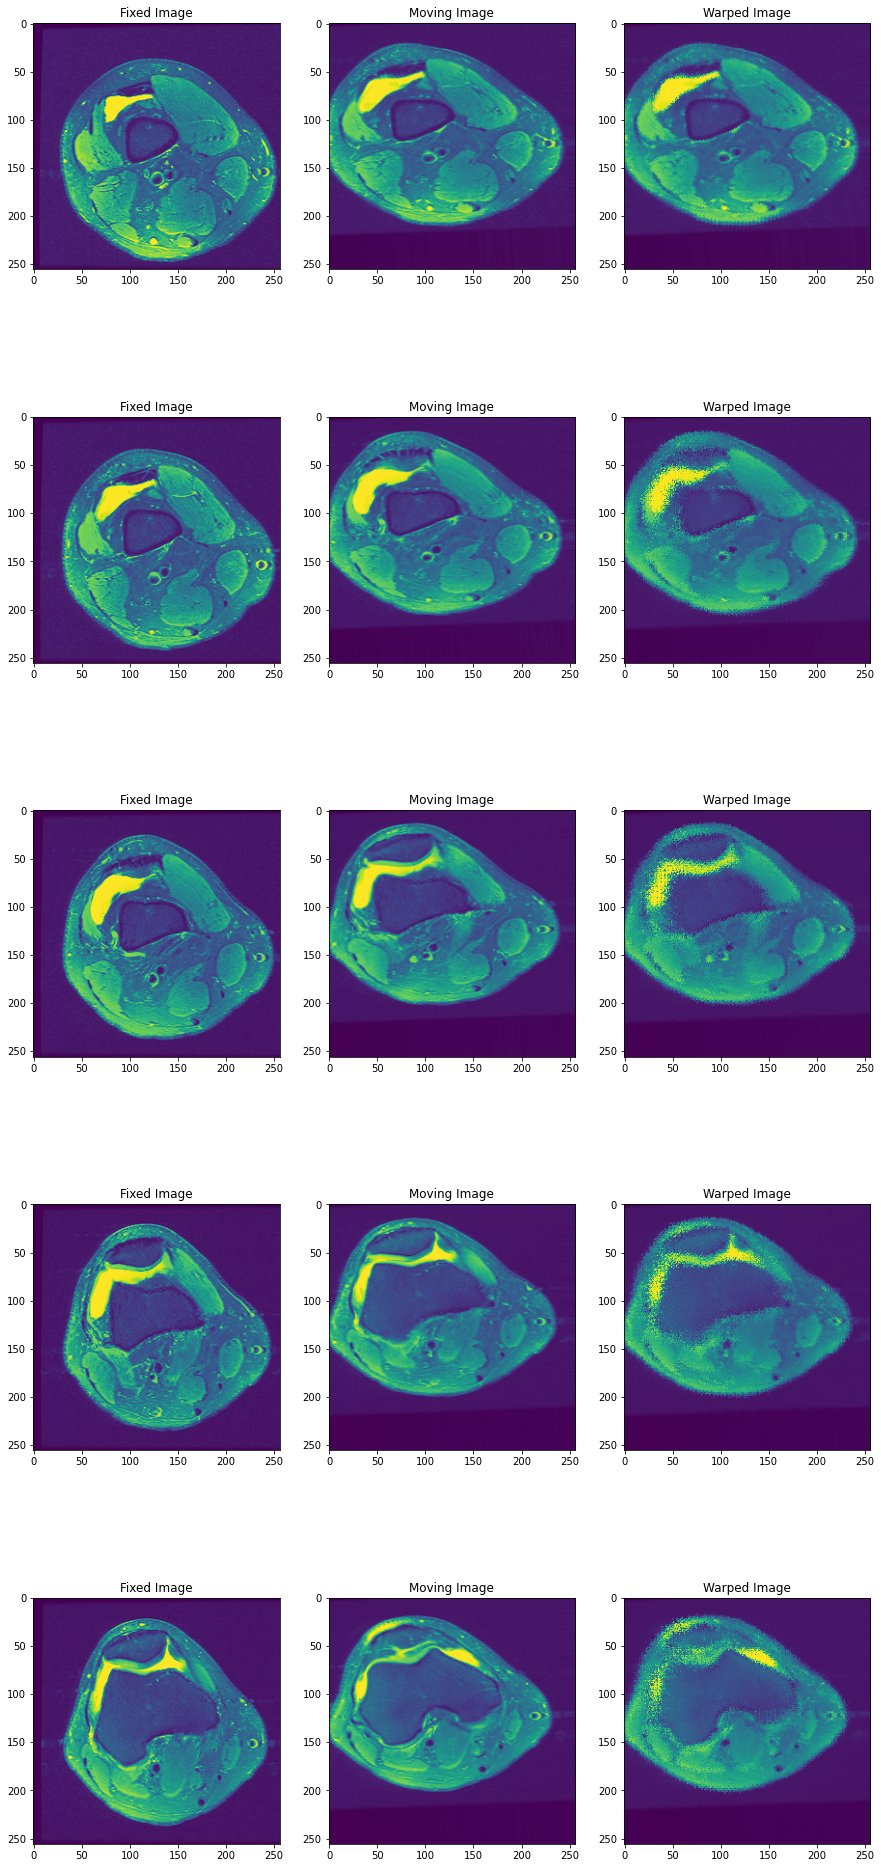

In [23]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(test_input[0,sliceToCheck + i * 5,:,:,1])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(test_input[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(test_generated_images[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()

In [ ]:
"""
1. Include more than 1 fixed image in the training dataset
Other TODOs:
4. UNet.
5. Incorporate affine transformation
"""